In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

In [6]:
from spaceoracle.models.estimators import GCNNWR 
from spaceoracle.tools.data import load_example_slideseq, filter_adata
from spaceoracle.tools.network import GeneRegulatoryNetwork

In [7]:
slideseq_data = load_example_slideseq('../data/slideseq/')
slideseq_data

[AnnData object with n_obs × n_vars = 39721 × 24649
     obs: 'cluster'
     uns: 'cluster_colors'
     obsm: 'X_spatial', 'spatial',
 AnnData object with n_obs × n_vars = 50058 × 19041
     obs: 'cluster'
     obsm: 'X_spatial', 'spatial',
 AnnData object with n_obs × n_vars = 41361 × 18972
     obs: 'cluster'
     obsm: 'X_spatial', 'spatial',
 AnnData object with n_obs × n_vars = 30242 × 25343
     obs: 'cluster'
     obsm: 'X_spatial', 'spatial']

In [8]:
adata = slideseq_data[0].copy()

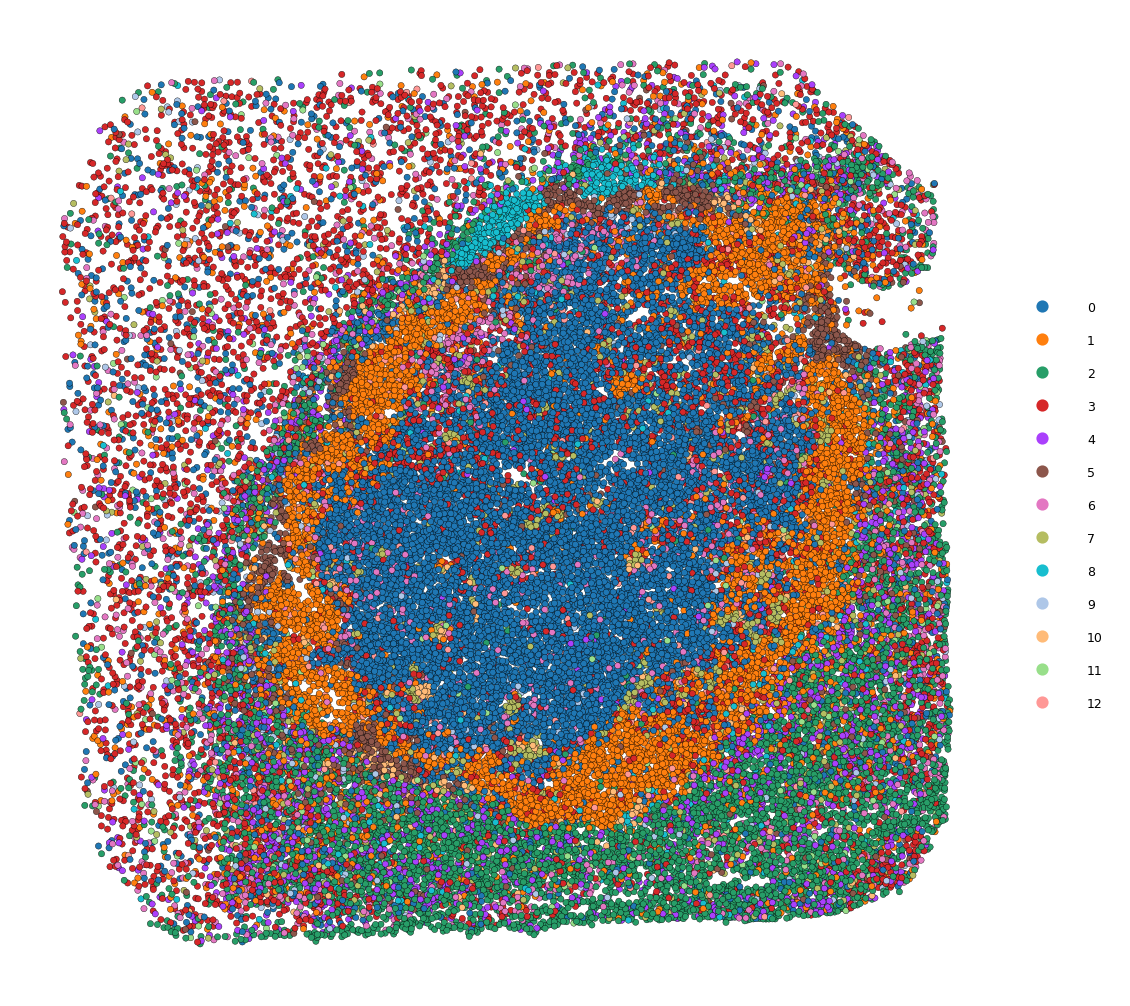

In [9]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, color='cluster', basis="spatial", s=25, show=False, edgecolor='black', linewidth=0.15)

fig = plt.gcf()
ax = plt.gca()

# Adjust the legend size
legend = ax.get_legend()
for text in legend.get_texts():
    text.set_fontsize(5)

for handle in legend.legendHandles:
    handle._sizes = [15]

plt.title('')
plt.axis('off')
plt.show()

In [10]:
adata.shape

(39721, 24649)

In [11]:
adata = filter_adata(adata, min_counts=500)

In [12]:
adata

View of AnnData object with n_obs × n_vars = 9984 × 2000
    obs: 'cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'spatial'
    layers: 'raw_count'

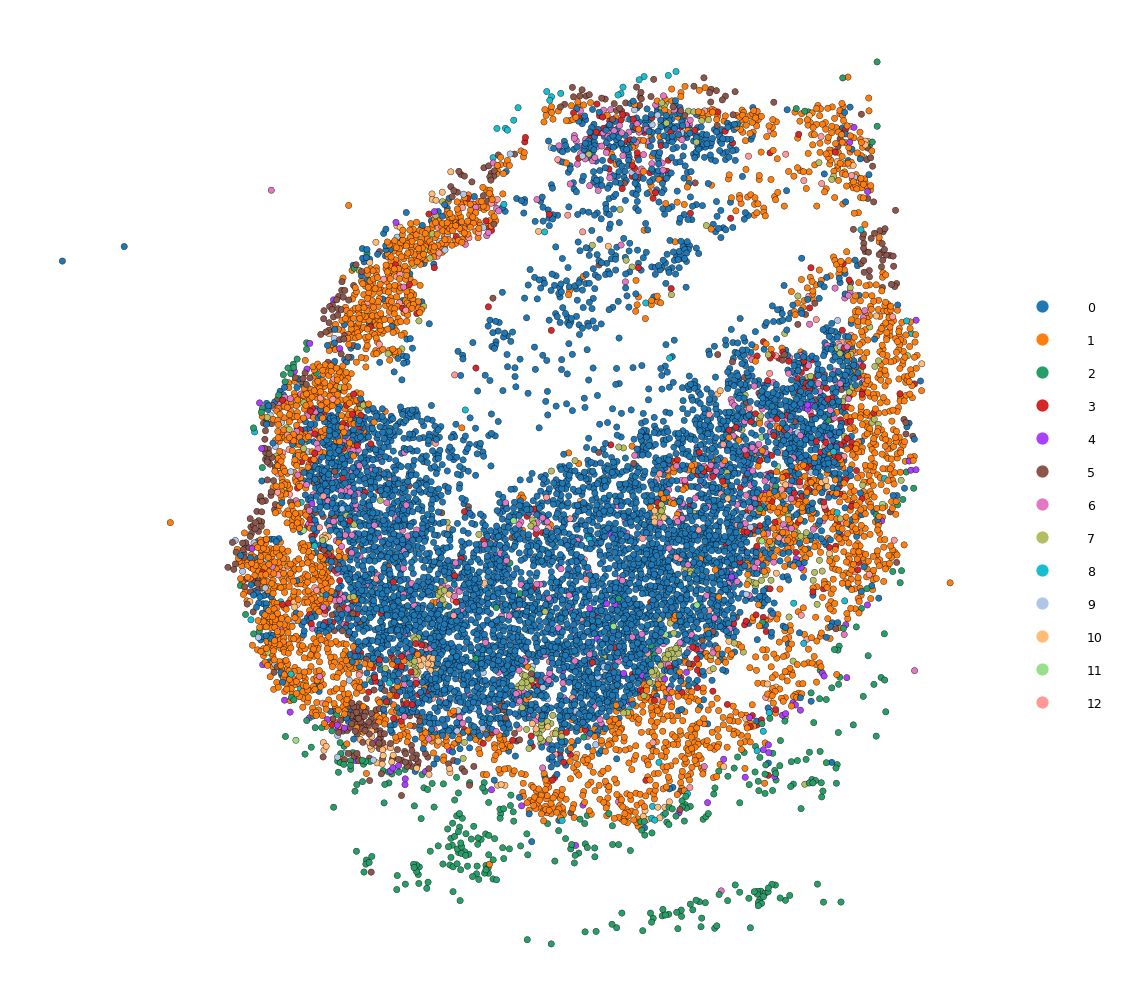

In [13]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, color='cluster', basis="spatial", s=25, show=False, edgecolor='black', linewidth=0.15)

fig = plt.gcf()
ax = plt.gca()

# Adjust the legend size
legend = ax.get_legend()
for text in legend.get_texts():
    text.set_fontsize(5)

for handle in legend.legendHandles:
    handle._sizes = [15]

plt.title('')
plt.axis('off')
plt.show()

In [14]:
from spaceoracle.models.spatial_map import distance, generate_grid_centers

In [16]:
import numpy as np
from tqdm import tqdm

def xy2spatial(x, y, m, n):
    assert len(x) == len(y)
    xmin, xmax, ymin, ymax = np.min(x), np.max(x), np.min(y), np.max(y)
    xy = np.column_stack([x, y]).astype(float)
    centers = generate_grid_centers(m, n, xmin, xmax, ymin, ymax)
    spatial_maps = np.zeros((len(x), m, n))
    with tqdm(total=len(xy), disable=True) as pbar:
        for s, coord in enumerate(xy):
            spatial_maps[s] = np.array([distance(coord, c) for c in centers]).reshape(m, n)
            pbar.update()
        
    return spatial_maps

In [112]:
import numpy as np
from tqdm import tqdm

def generate_grid_centers(m, n, xmin, xmax, ymin, ymax):
    x_centers = np.linspace(xmin, xmax, m)
    y_centers = np.linspace(ymin, ymax, n)
    return np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)

def distance(coord1, coord2):
    return np.linalg.norm(coord1 - coord2)

def xyc2spatial(x, y, c, m, n):
    assert len(x) == len(y) == len(c)
    xmin, xmax, ymin, ymax = np.min(x), np.max(x), np.min(y), np.max(y)
    xy = np.column_stack([x, y]).astype(float)
    xyc = np.column_stack([x, y, c]).astype(float)
    
    centers = generate_grid_centers(m, n, xmin, xmax, ymin, ymax)
    clusters = np.unique(c).astype(int)
    
    spatial_maps = np.zeros((len(clusters), m, n))
    
    with tqdm(total=len(xyc), disable=False) as pbar:
        
        for s, coord in enumerate(xyc):
            x, y, cluster = coord
            distances = np.array([distance([x, y], center) for center in centers]).reshape(m, n)
            nearest_center_idx = np.argmin(distances)
            u, v = np.unravel_index(nearest_center_idx, (m, n))
        
            spatial_maps[int(cluster)][u, v] += 1
            
            pbar.update()
        
        
    return spatial_maps

In [114]:
sp_maps = xyc2spatial(x[:500], y[:500], c[:500], m, n)
sp_maps.shape

100%|██████████| 6500/6500 [00:14<00:00, 439.76it/s]


(500, 13, 32, 32)

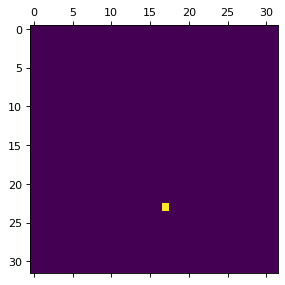

In [116]:
plt.rcParams["figure.figsize"] = (1, 1)
plt.rcParams['figure.dpi'] = 80
plt.matshow(sp_maps[3][0])

In [76]:
x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1]
c = np.array(adata.obs['cluster'].values)
m = 32
n = 32

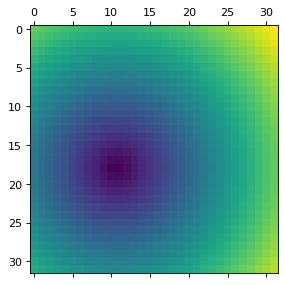

In [22]:
plt.rcParams["figure.figsize"] = (1, 1)
plt.rcParams['figure.dpi'] = 80
plt.matshow(sp_maps[111])

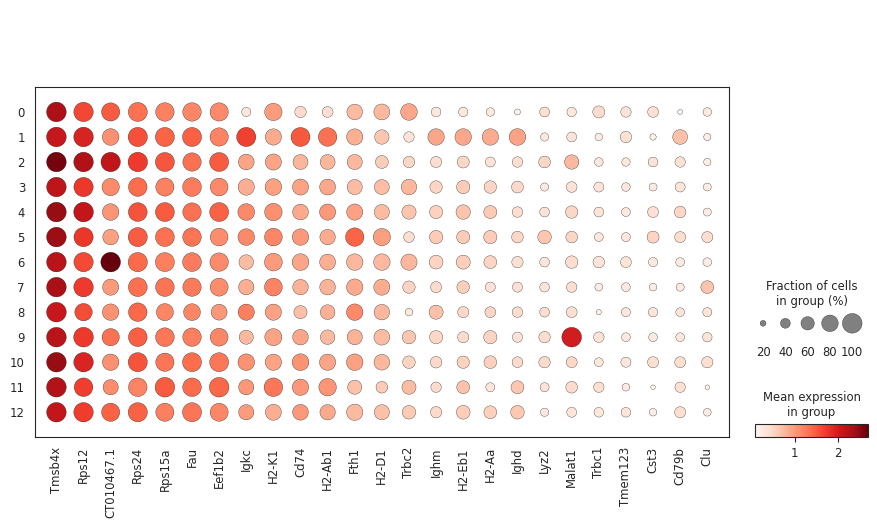

In [114]:
plt.rcParams["figure.figsize"] = (1, 1)
plt.rcParams['figure.dpi'] = 100
sc.pl.dotplot(adata, var_names=adata.var.means.sort_values(ascending=False)[:25].index, groupby='cluster')

In [115]:
adata.var.means.sort_values(ascending=False)[:15]

Tmsb4x        2.314449
Rps12         1.864198
CT010467.1    1.704301
Rps24         1.542029
Rps15a        1.416875
Fau           1.389121
Eef1b2        1.290448
Igkc          1.219202
H2-K1         1.121229
Cd74          1.079870
H2-Ab1        0.988318
Fth1          0.970740
H2-D1         0.875278
Trbc2         0.866577
Ighm          0.756234
Name: means, dtype: float64

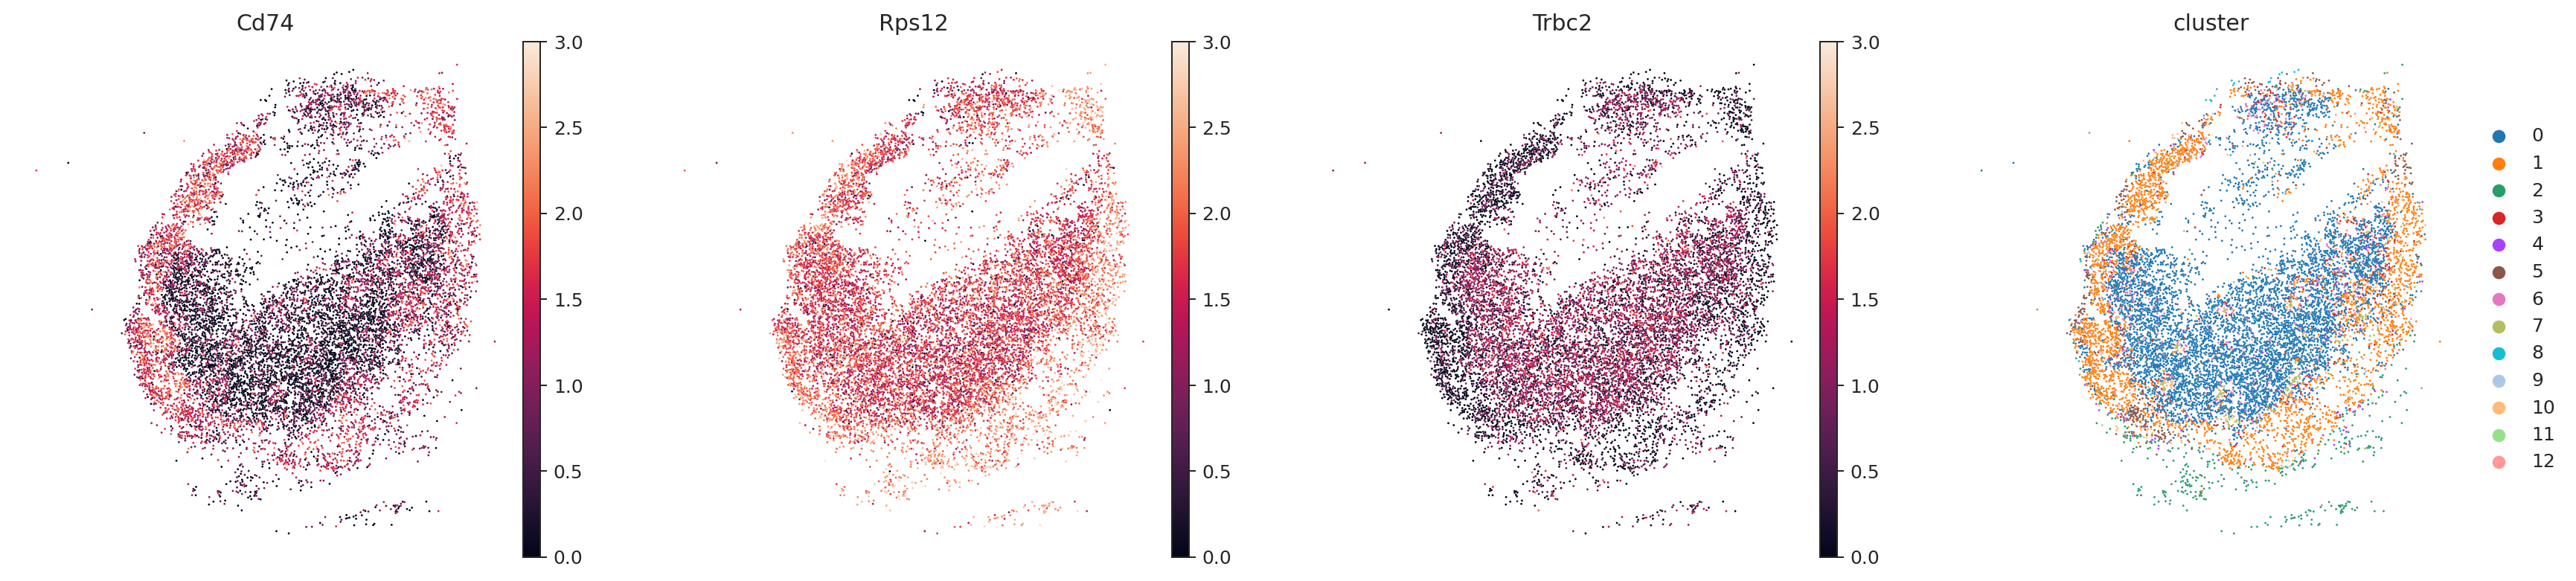

In [118]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, color=['Cd74', 'Rps12', 'Trbc2', 'cluster'], 
                frameon=False, basis="spatial", s=5, show=False, vmin=0, vmax=3)
plt.axis('off')
plt.show()

In [119]:
grn = GeneRegulatoryNetwork()

In [136]:
target_gene = 'Cd74'

In [137]:
regulators = grn.get_regulators(adata, target_gene=target_gene)
regulators, len(regulators)

(['Atf3',
  'Bcl11a',
  'Ebf1',
  'Ebf3',
  'Egr2',
  'Gata1',
  'Gata2',
  'Mef2a',
  'Mef2c',
  'Pax5',
  'Pou2f2',
  'Prdm9',
  'Snai3',
  'Stat2',
  'Taf1',
  'Tal1'],
 16)

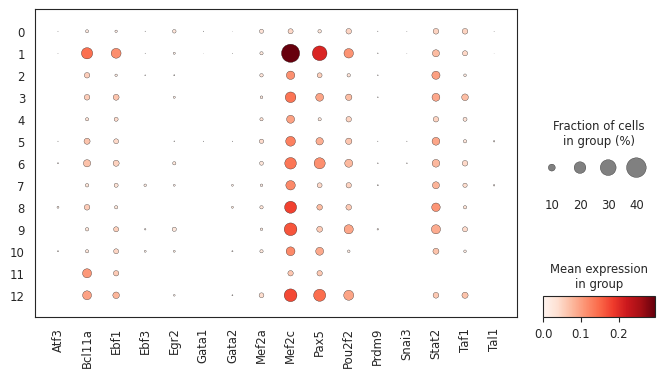

In [138]:
%matplotlib inline
sc.pl.dotplot(adata, var_names=regulators, groupby='cluster', figsize=(8, 4))

In [139]:
from spaceoracle.models.estimators import GeoCNNEstimator

In [140]:
estimator = GeoCNNEstimator()

In [141]:
X = adata.to_df()[regulators]
X

Atf3  Bcl11a      Ebf1  Ebf3  Egr2  Gata1  Gata2     Mef2a  \
AAAAATCGCGTCCA   0.0     0.0  0.643342   0.0   0.0    0.0    0.0  0.000000   
AAAACCTCACATTT   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   
AAAACGTGATCCTA   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   
AAAACTATTTAAGG   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   
AAAAGATGCTCAGC   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   
...              ...     ...       ...   ...   ...    ...    ...       ...   
TTTTTTCGACAGAG   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   
TTTTTTCGCGGCTA   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   
TTTTTTGGGCTGGT   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   
TTTTTTGTACGATT   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.857282   
TTTTTTGTTTTCTA   0.0     0.0  0.000000   0.0   0.0    0.0    0.0  0.000000   

                   Mef2c  Pax5    Pou2f2  Prdm9  Snai3     Stat2      Taf1  \
AAAAATCGCGTCCA  0.000000   0.0  0.000000    0.0    0.0  0.000000  0.000000   
AAAACCTCACATTT  0.000000   0.0  0.458739    0.0    0.0  0.000000  0.000000   
AAAACGTGATCCTA  0.000000   0.0  0.000000    0.0    0.0  0.691110  0.000000   
AAAACTATTTAAGG  0.000000   0.0  0.000000    0.0    0.0  0.000000  0.000000   
AAAAGATGCTCAGC  1.512969   0.0  0.000000    0.0    0.0  0.000000  0.000000   
...                  ...   ...       ...    ...    ...       ...       ...   
TTTTTTCGACAGAG  0.000000   0.0  0.000000    0.0    0.0  0.000000  0.646273   
TTTTTTCGCGGCTA  0.000000   0.0  0.000000    0.0    0.0  0.000000  0.000000   
TTTTTTGGGCTGGT  0.000000   0.0  0.423997    0.0    0.0  0.423997  0.000000   
TTTTTTGTACGATT  0.000000   0.0  0.000000    0.0    0.0  0.000000  0.000000   
TTTTTTGTTTTCTA  0.000000   0.0  0.000000    0.0    0.0  0.450997  0.000000   

                Tal1  
AAAAATCGCGTCCA   0.0  
AAAACCTCACATTT   0.0  
AAAACGTGATCCTA   0.0  
AAAACTATTTAAGG   0.0  
AAAAGATGCTCAGC   0.0  
...              ...  
TTTTTTCGACAGAG   0.0  
TTTTTTCGCGGCTA   0.0  
TTTTTTGGGCTGGT   0.0  
TTTTTTGTACGATT   0.0  
TTTTTTGTTTTCTA   0.0  

[9984 rows x 16 columns]

In [142]:
y = adata.to_df()[[target_gene]]
y

Cd74
AAAAATCGCGTCCA  0.000000
AAAACCTCACATTT  0.772030
AAAACGTGATCCTA  1.095895
AAAACTATTTAAGG  0.000000
AAAAGATGCTCAGC  1.744014
...                  ...
TTTTTTCGACAGAG  0.000000
TTTTTTCGCGGCTA  0.000000
TTTTTTGGGCTGGT  0.000000
TTTTTTGTACGATT  1.860506
TTTTTTGTTTTCTA  0.760690

[9984 rows x 1 columns]

In [143]:
xy = adata.obsm['spatial']
xy

ArrayView([[-2583.5,  2490.7],
           [-3975.2,  2855.4],
           [-1578.6,  2046. ],
           ...,
           [-3547.4,  2483.1],
           [-2052.1,  2937.7],
           [-2025.5,  2342.3]])

In [155]:
adata.shape

(9984, 2000)

In [167]:
estimator.fit(X.values[:9000, :], y.values[:9000], xy[:9000, :], init_betas='ols', max_epochs=200, learning_rate=3e-3, spatial_dim=128)

MSE: 0.3014 | OLS: 0.5924: 100%|██████████| 200/200 [06:19<00:00,  1.90s/it]


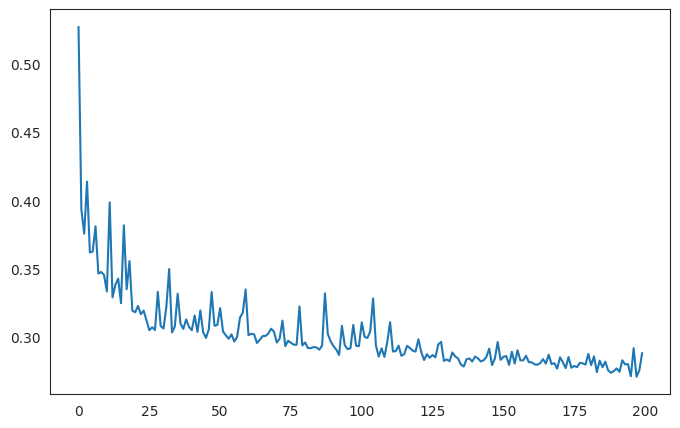

In [168]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses)
plt.show()

In [169]:
betas, y_pred = estimator.get_betas(X.values[9000:, :], xy[9000:, :])

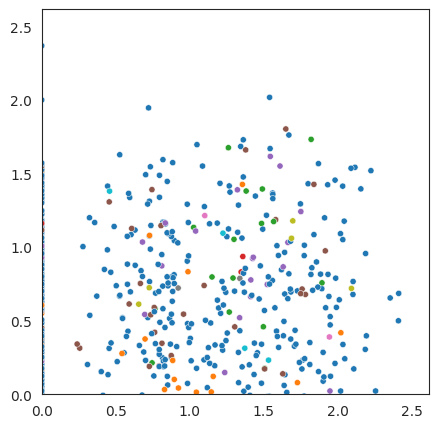

In [170]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 100
sns.scatterplot(x=y.values[9000:, :].reshape(-1), y=y_pred.reshape(-1), s=20, c=adata.obs.cluster.values[9000:], cmap='tab10')
plt.xlim(y.values[9000:, :].min(), y.values[9000:, :].max())
plt.ylim(y.values[9000:, :].min(), y.values[9000:, :].max())
plt.show()

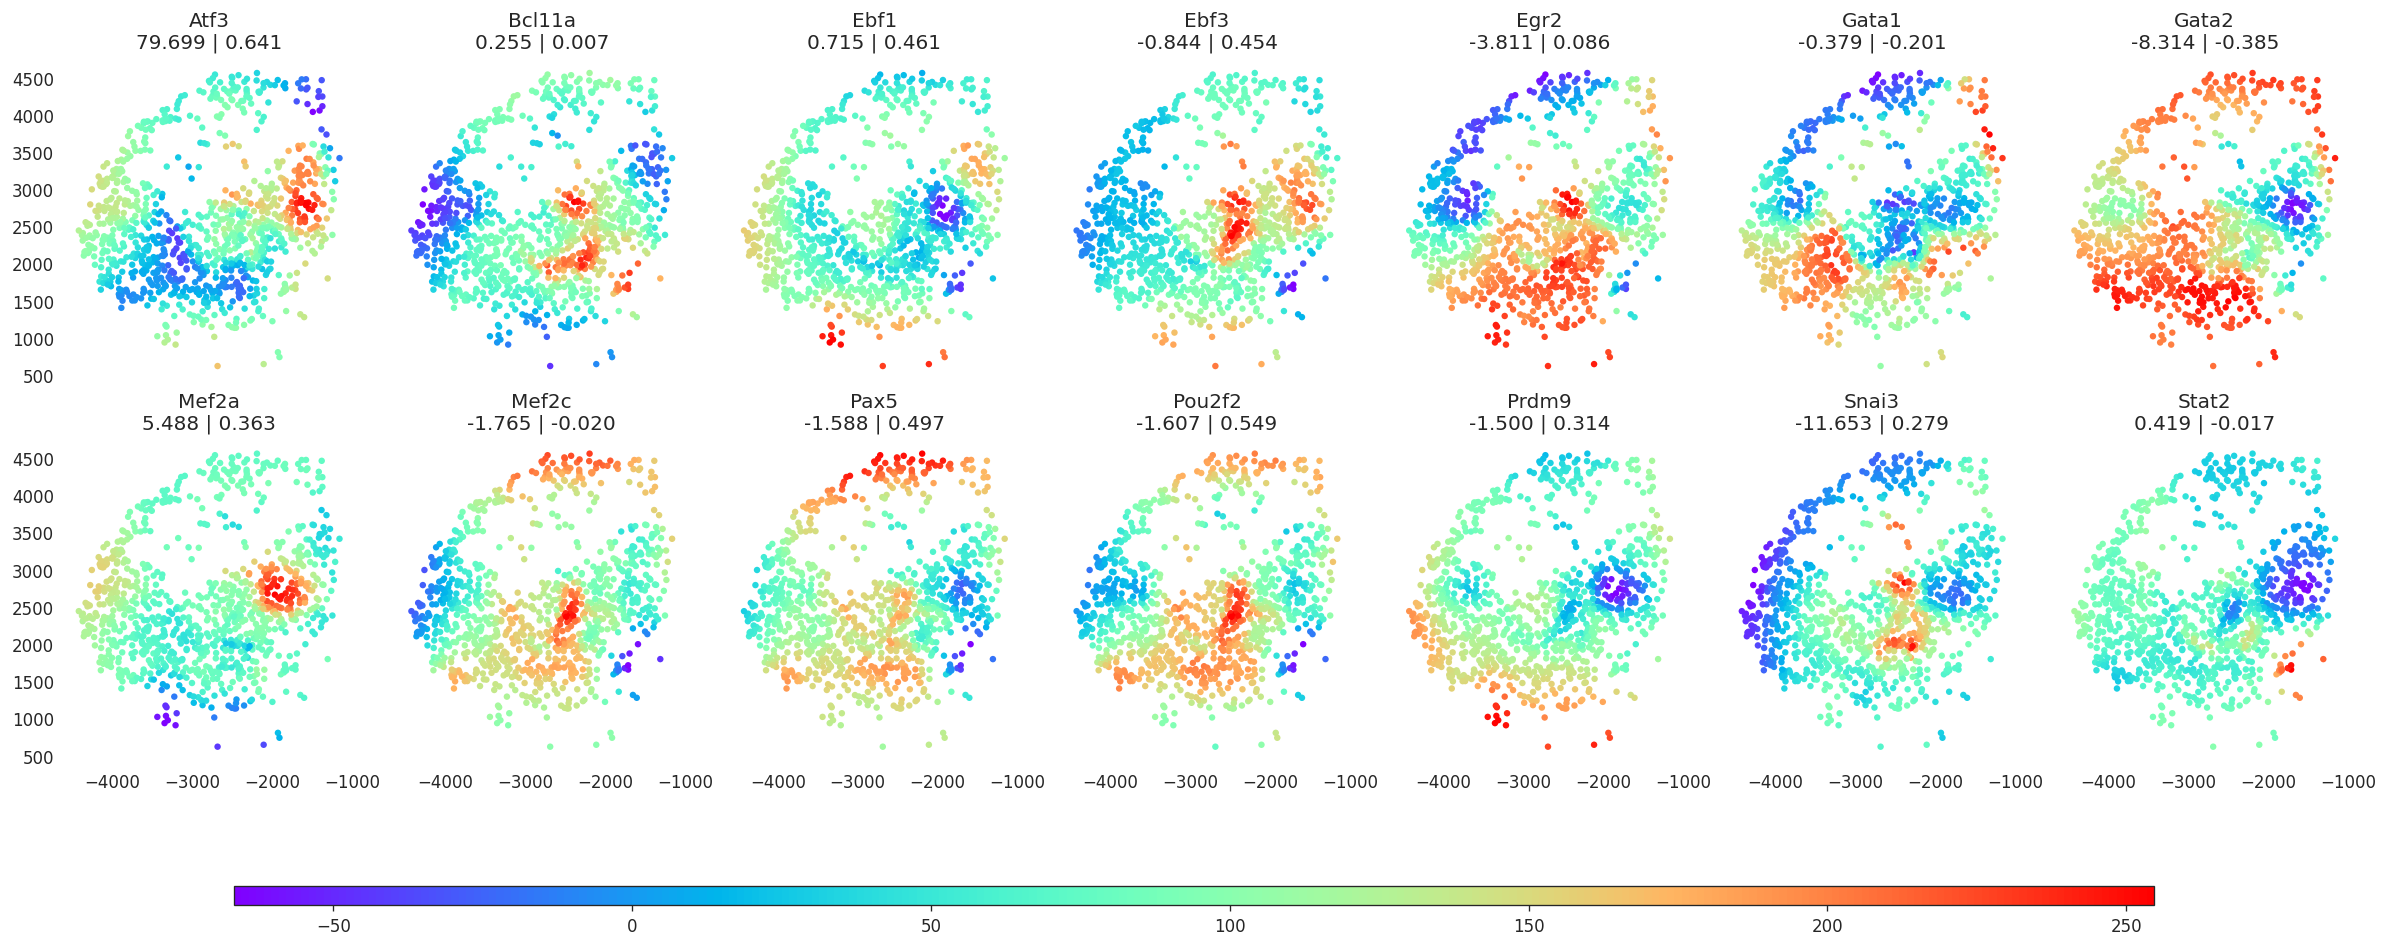

In [171]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=120, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata.obsm['spatial'][9000:, 0], y=adata.obsm['spatial'][9000:, 1], 
                s=15, c=betas[:, i+1], cmap='rainbow', ax=axs[i], edgecolor=None, linewidth=0)
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{regulators[ix]}\n{beta_means[ix+1]:.3f} | {estimator.beta_init[ix]:.3f}')

# Adjust the layout to make space for the colorbar
plt.tight_layout()
f.subplots_adjust(bottom=0.2)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')

plt.show()